<a href="https://colab.research.google.com/github/david-oruna/pneumonia-classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de neumonía en rayos X pediátricos de SCI

Este proyecto consiste en entrenar una CNN (Red Neuronal Convolusional) para detectar pacientes con pneumonia utilizando una dataset de Rayos X pediátricos. Utilizaremos técnicas de preprocesamiento (aumentación y normalización) y luego aplicaremos transfer learning con ResNet50.

Nos basamos en el tutorial de transfer learning de tensorflow:
https://www.tensorflow.org/tutorials/images/transfer_learning



# Preprocesamiento
## 1. Preparando el dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/keys/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c sci-pediatric-chest-x-ray-pneumonia-classificatio


100% 1.14G/1.14G [00:18<00:00, 55.0MB/s]
100% 1.14G/1.14G [00:18<00:00, 66.4MB/s]


In [ ]:
! unzip -q "sci-pediatric-chest-x-ray-pneumonia-classificatio.zip"

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras


In [ ]:
train_dir = '/content/train/train'


In [ ]:

img_height = 224
img_width = 224
batch_size = 32

# Aumento de data
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(1.0 / 255),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

# Creamos training dataset con aumento
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


# Testing dataset (sin aumento)
val_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Aplicamos prefetch para asegurar que la data preprocesada este disponible para entrenar el modelo
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3816 files belonging to 2 classes.
Using 3053 files for training.
Found 3816 files belonging to 2 classes.
Using 763 files for validation.


Image shape: (32, 224, 224, 3)
Label shape: (32, 1)
Image data type: <dtype: 'float32'>
Label data type: <dtype: 'float32'>


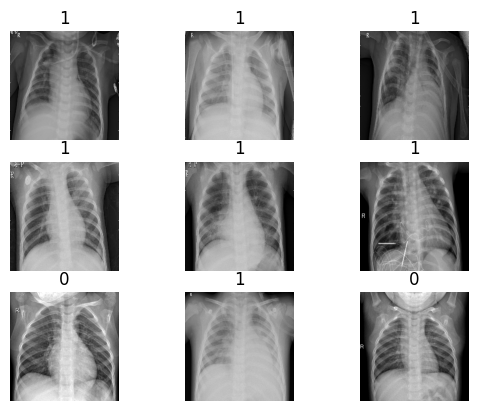

In [ ]:
import matplotlib.pyplot as plt

# Mostramos algunas radiografías
for images, labels in train_ds.take(1):  # primer batch

    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)
    print("Image data type:", images.dtype)
    print("Label data type:", labels.dtype)

    images = images.numpy()*255  # Desnormalizamos para plot

    for i in range(9):  # 9 radiografías
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(int(labels[i]))  # (0 - Normal, 1 - Pneumonia)
        plt.axis("off")
    plt.show()

# Transfer Learning

Ahora que ya tenemos la dataset lista (preprocesada, aumentada y dividida en training y validation), vamos a entrenar el modelo CNN utilizando la técnica Transfer Learning.

En esta ocasión usaremos ResNet50, un conocido y excelente CNN de clasificación de imágenes, que ha mostrado buenos resultados en tareas relacionadas a imagenes médicas, incluyendo clasificación de radiografías toráxicas. (1)

## 1. Feature Extraction

In [ ]:

# Cargamos el modelo. No se incluye la capa top o de salida pues es la capa de clasificación que agregaremos para el output deseado.

base_model = keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)
)


# Congelamos para que no se actualizen los pesos de las capas de ResNet durante el entrenamiento
# Esto significa que utilizaremos el modelo para extraer características del dataset (Feature Extraction)

base_model.trainable = False

# Un ojo a ResNet
base_model.summary()


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

# Agregamos capa de clasificación personalizada
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)


x.shape

#(n de imagenes por batch, h, w, features)

(None, 7, 7, 2048)

In [ ]:
x = keras.layers.GlobalAveragePooling2D()(x) # Promediar los mapas de características en las 2 dimensiones (7x7 en este caso), resultando en un solo valor por cada canal de características dentro de cada mapa (Vectorizar)
x.shape
# La forma es (None (Debido a que el numero de imagenes por batch puede variar), y 2048 (pues es el numero de características que produce Resnet por imagen))

(None, 2048)

In [ ]:

outputs = keras.layers.Dense(1, activation='sigmoid')(x) # Resultado binario
model = keras.Model(inputs, outputs)
base_learning_rate = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate = base_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

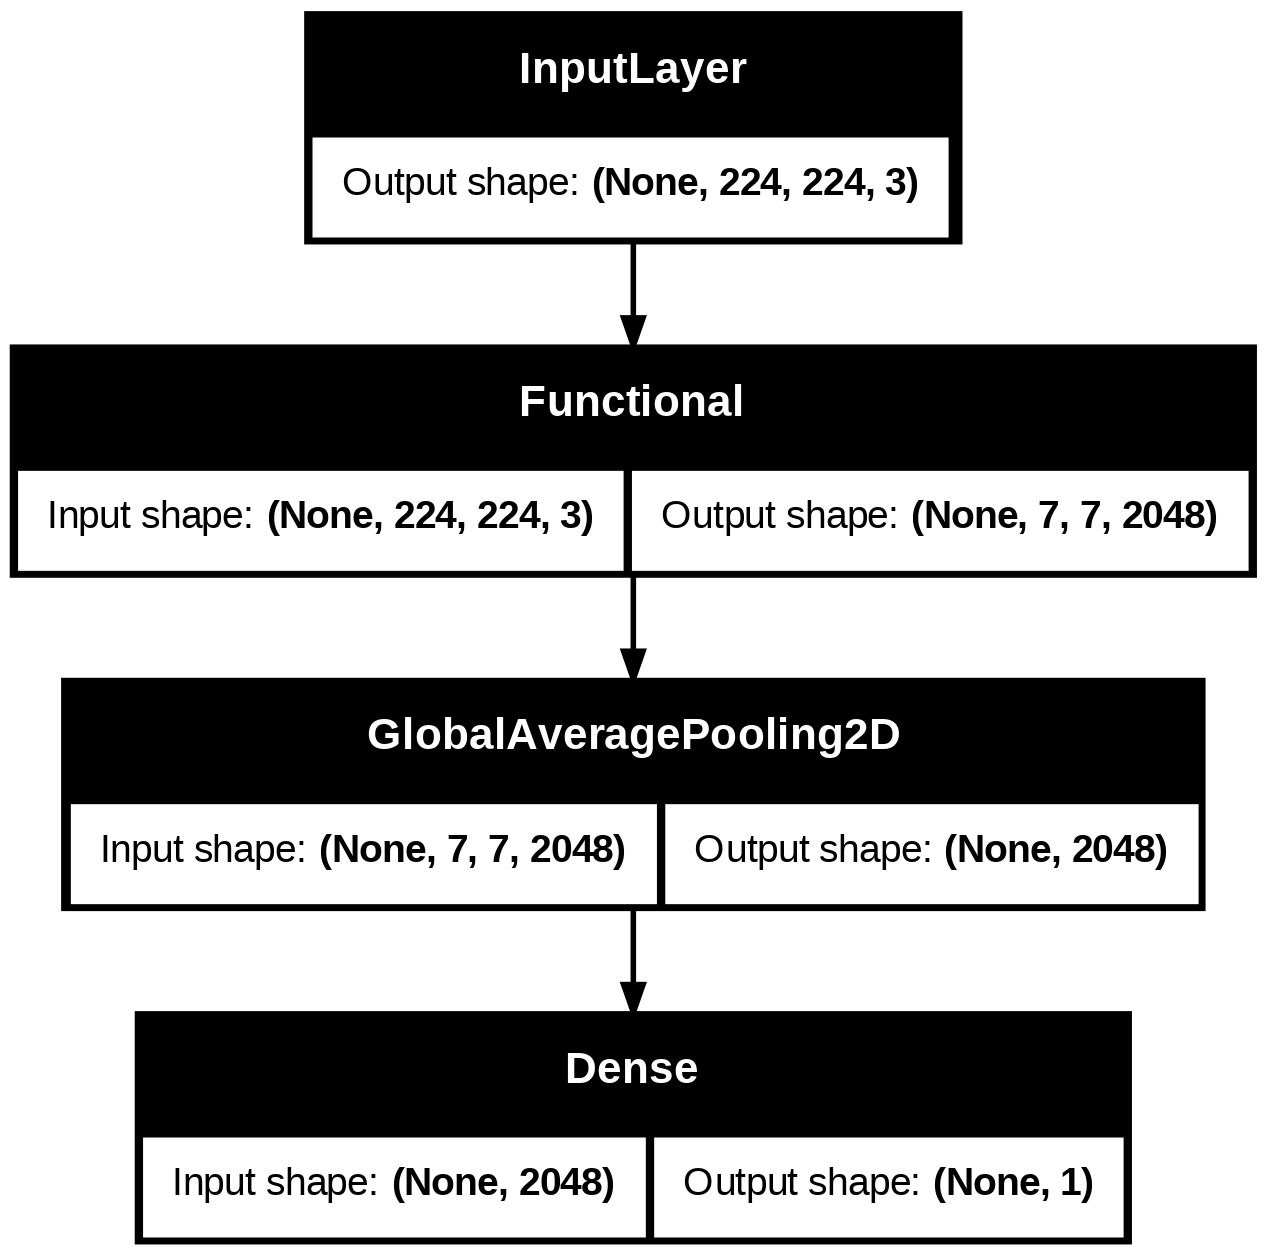

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, )

In [ ]:

# Y a quemar la PC!
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 433ms/step - accuracy: 0.7225 - loss: 0.6280 - val_accuracy: 0.9161 - val_loss: 0.3670
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 318ms/step - accuracy: 0.7224 - loss: 0.5935 - val_accuracy: 0.6907 - val_loss: 0.5762
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 287ms/step - accuracy: 0.7225 - loss: 0.5900 - val_accuracy: 0.4325 - val_loss: 0.8447
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.7288 - loss: 0.5808 - val_accuracy: 0.1900 - val_loss: 1.1924
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - accuracy: 0.7236 - loss: 0.5829 - val_accuracy: 0.0734 - val_loss: 1.5828
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 279ms/step - accuracy: 0.7216 - loss: 0.5813 - val_accuracy: 0.0197 - val_loss: 2.0052
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 323ms/step - accuracy: 0.7330 - loss: 0.5673 - val_accuracy: 0.0026 - val_loss: 2.4860
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 282ms/step - accuracy: 0.7253 - loss: 0.5716 - val_accu

In [ ]:
loss, accuracy = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.0000e+00 - loss: 3.8845
initial loss: 3.87
initial accuracy: 0.00


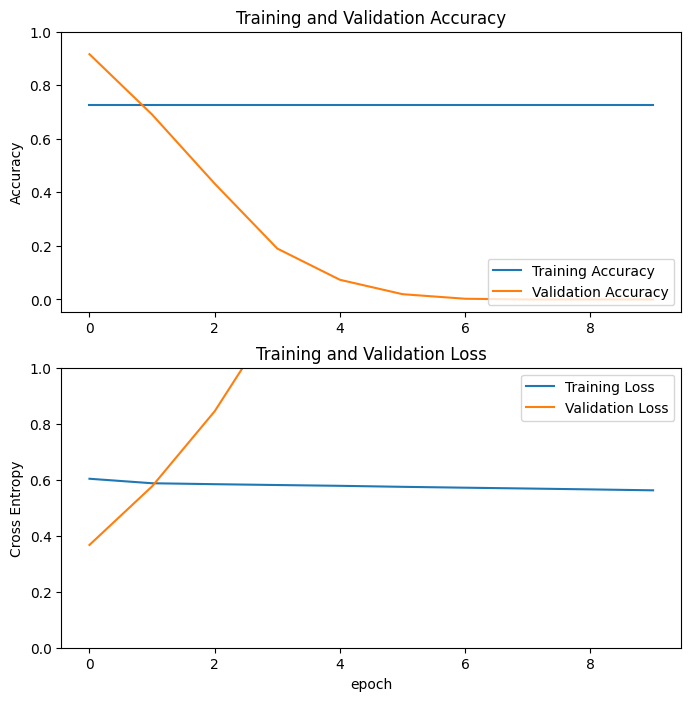

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Como se observa en el gráfico este es un claro caso de overfitting. Esta situación es común cuando se utilizan modelos robustos como ResNet5, pues se memorizan el dataset de entrenamiento pero no hallan características para poder predecir nuevos casos correctamente.


## 2. Fine Tuning

Pasaremos al segundo paso de Transfer Learning, entrenar algunas capas del modelo con nuestra propia data (Fine Tuning).

In [ ]:
# Check the format of your datasets
for images, labels in train_ds.take(1):
    print("Image shape:", images.shape)
    print("Labels shape:", labels.shape)

Image shape: (32, 224, 224, 3)
Labels shape: (32, 1)


In [ ]:
input_shape = (224, 224, 3)

base_model = keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)
)


inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

# Contruimos el modelo con tf.keras.Model API
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


# Fine-tuning setup
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Bloqueamos las 20 primeras capas (20/50)
    layer.trainable = False

learning_rate = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Agregamos callbacks para monitorear el entrenamiento
callbacks = [

    # Reducir learning rate
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7
    ),

    # Prevenir overfitting
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]



In [ ]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,120,705 (92.01 MB)

 Trainable params: 14,979,073 (57.14 MB)

 Non-trainable params: 9,141,632 (34.87 MB)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 436ms/step - accuracy: 0.7191 - auc_11: 0.8748 - loss: 5.2538 - val_accuracy: 0.2438 - val_auc_11: 0.0000e+00 - val_loss: 5.8072 - learning_rate: 1.0000e-05
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.9107 - auc_11: 0.9628 - loss: 4.7277 - val_accuracy: 0.6488 - val_auc_11: 0.0000e+00 - val_loss: 5.2510 - learning_rate: 1.0000e-05
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.9269 - auc_11: 0.9766 - loss: 4.6226 - val_accuracy: 0.8204 - val_auc_11: 0.0000e+00 - val_loss: 4.9653 - learning_rate: 1.0000e-05
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.9374 - auc_11: 0.9790 - loss: 4.5528 - val_accuracy: 0.8820 - val_auc_11: 0.0000e+00 - val_loss: 4.8735 - learning_rate: 1.0000e-05
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 292ms/step - accuracy: 0.9469 - auc_11: 0.9824 - loss: 4.4813 - val_accuracy: 0.9305 - val_auc_11: 0.0000e+00 - val_loss: 4.6817 - learning_rate: 1.0000e-05
Epoch

In [ ]:
loss, accuracy, auc = model.evaluate(val_ds)
print("Loss: {:.2f}".format(loss))
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9722 - auc_11: 0.0000e+00 - loss: 4.1378
Loss: 4.21
Accuracy: 0.97
AUC: 0.00


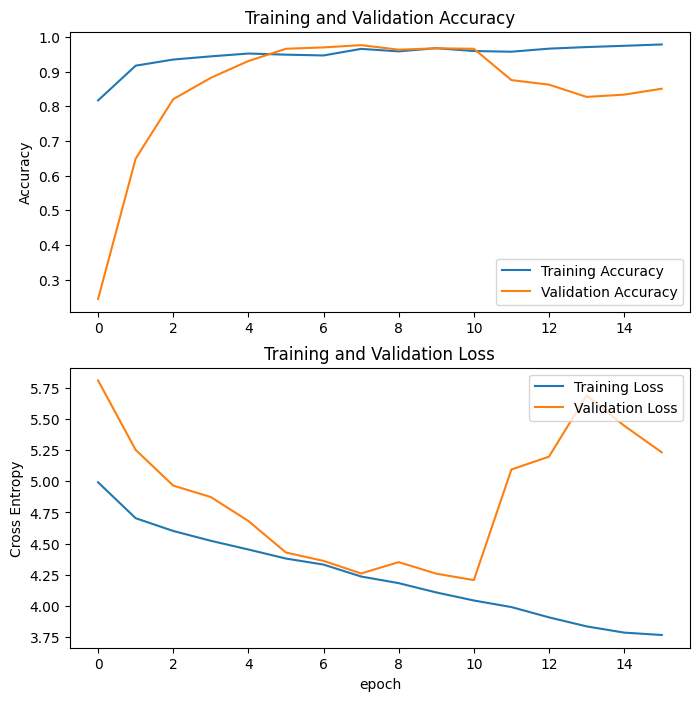

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

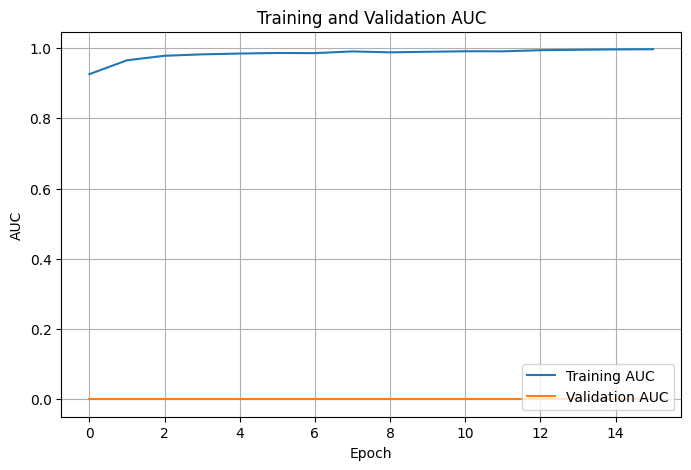

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['auc_11'], label='Training AUC')
plt.plot(history.history['val_auc_11'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
model.save("best.keras")

In [ ]:
# Generamos csv de resultados pa enviar al profe
import pandas as pd
test_dir = '/content/test/test'
test_ds = image_dataset_from_directory(
    test_dir,
    labels=None,
    label_mode=None,
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    seed=123
)


test_ds = test_ds.map(lambda x: float(x) / 255.0)
predictions = model.predict(test_ds).flatten()
predictions = np.where(predictions > 0.5, 1, 0)

df = pd.DataFrame({'Predictions': predictions})
df.to_csv('predictions.csv', index=False)


Found 2040 files.
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step


In [ ]:
!kaggle competitions submit -c sci-pediatric-chest-x-ray-pneumonia-classificatio -f submission.csv -m "🤑"

# Referencias

1. Osman Güler, Kemal Polat (2022). Neural Network Learning of Context-Dependent Affordances. Journal of Artificial Intelligence and Systems, 4, 107–106. https://doi.org/10.33969/AIS.2022040107.

